# Разработка A/B-тестирования и анализ результатов

Вы работаете продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Вас, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Вы будете работать с тремя таблицами:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Ваши задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.
Важнейшик метрики продукта выбраны: число зарегистрированных пользователей и число просмотренных страниц в приложении. Успешными сессиями считали те, в рамках которых пользователь просмотрел 4 и более страниц. Проверим, является ли изменение в метрике доли успешных сессий статистически значимым

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработайте с историческими данными приложения:

- Импортируйте библиотеку pandas.

- Считайте и сохраните в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведите на экран первые пять строк полученного датафрейма.

In [1]:
import pandas as pd
# для построения графика нам необходимо импортировать бибилиотеку matplotlib
import matplotlib.pyplot as plt
from math import ceil
# для t-теста
from scipy import stats
# для z-теста
from statsmodels.stats.proportion import proportions_ztest


In [2]:
sessions_history=pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитайте количество уникальных сессий `session_id`.

- Выведите на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберите любого из них.

- Изучите таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [3]:
# считаем число уникальных сессий на пользователя
unique_sessions_count = sessions_history.groupby('user_id')['session_id'].nunique()
# выделяем пользователя с наибольшим количеством сессий
top_user = unique_sessions_count.idxmax() 
# данные для этого пользователя из sessions_history
top_user_data = sessions_history[sessions_history['user_id'] == top_user]
top_user_data

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


Пользователь 10E0DEFC1ABDBBE0 установил приложение 14.08.2025 и начиная с этой даты до 25.08.2025 года заходил туда каждодневно, увеличивая количество сессий на 1 (с 1 до 10 оответственно), при этом он не зарегистрирован, просматривает от 1 до 4 страниц с андроида.

#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируйте, как менялось число регистраций в приложении за время его существования.

- Агрегируйте исторические данные и рассчитайте число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считайте, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Постройте линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразите их на одном графике.

- Постройте отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

- На обоих графиках должны быть заголовок, подписанные оси X и Y, сетка и легенда.

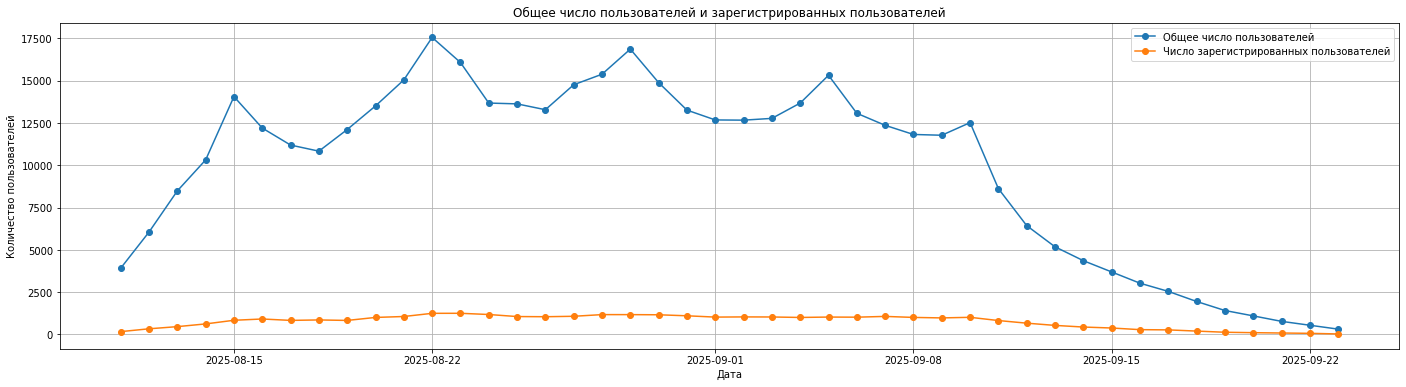

In [4]:
# переводим столбец в формат даты
sessions_history['session_date'] = pd.to_datetime(sessions_history['session_date'])

# Агрегируем исторические данные по дате
agg_data = sessions_history.groupby('session_date').agg(
    unique_users=('user_id', 'nunique'),
    registered_users=('registration_flag', lambda x: (x == 1).sum())
).reset_index() # убираем индекс

# строим графики общего числа пользователей и зарегистрированных пользователей
plt.figure(figsize=(24, 6))
plt.plot(agg_data['session_date'], agg_data['unique_users'], label='Общее число пользователей', marker='o')
plt.plot(agg_data['session_date'], agg_data['registered_users'], label='Число зарегистрированных пользователей',
         marker='o')
plt.title('Общее число пользователей и зарегистрированных пользователей')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.grid()
plt.legend()

plt.show()

Графики общего числа пользователей и числа зарегистрировнных пользователей имеют похожие направления роста с момента начала до 22.08.2025, удержания на достаточно высоком уровне до 08.09.2025, после чего снижением к концу сентября 2025.

Число регистраций в абсолютном значении в приложении за время его существования чсначала росло, затем сохраняло свои значения, а к концу сентября упало, при этом отсутствовали резкие перепады, плавные подъем и спад.



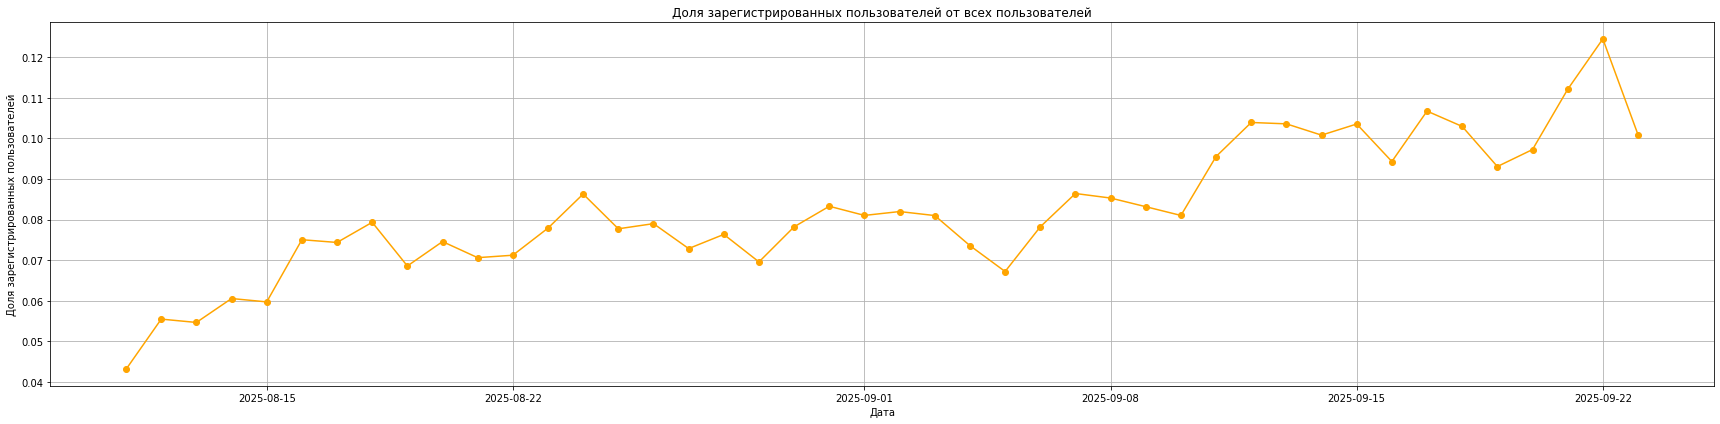

In [5]:
# строим отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням
plt.figure(figsize=(24, 6))
agg_data['registered_ratio'] = agg_data['registered_users'] / agg_data['unique_users']
plt.plot(agg_data['session_date'], agg_data['registered_ratio'], label='Доля зарегистрированных пользователей', marker='o', 
         color='orange')
plt.title('Доля зарегистрированных пользователей от всех пользователей')
plt.xlabel('Дата')
plt.ylabel('Доля зарегистрированных пользователей')
plt.grid()
# Показать графики
plt.tight_layout()
plt.show()

При этом, мы видим устойчивую тенденцию роста доли зарегистрированных пользователей с самого начала до 22.09.2025. При этом,график имеет периоды незначительные перепады то роста, то падения, но тенденция роста с максимумом  22.09.2025 налицо.
Важно учитывать, что высокая вариативность доли может быть связана с уменьшением количества наблюдений к концу периода.

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы на то, что он зарегистрируется и оплатит подписку.

- Найдите количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29160 сессиях, две страницы в 105536 сессиях и так далее.

- Постройте столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

- На диаграмме должны быть заголовок, подписанные оси X и Y.

In [6]:
sessions_count = sessions_history.groupby('page_counter')['session_number'].sum().reset_index()
sessions_count

,page_counter,session_number
0,1,69664
1,2,251400
2,3,397524
3,4,250965
4,5,62823
5,6,6183
6,7,208


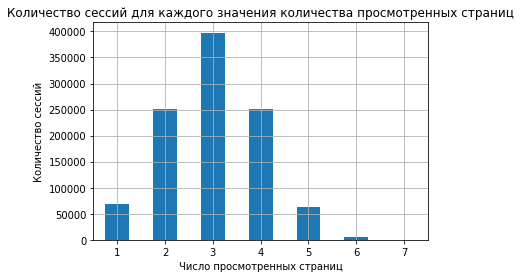

In [7]:
#Строим столбчатую диаграмму 
sessions_count.plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               legend=False,
               x='page_counter', 
               y='session_number',
               rot=0,
               title=f'Количество сессий для каждого значения количества просмотренных страниц'
)

# Настраиваем оформление графика
plt.xlabel('Число просмотренных страниц')
plt.ylabel('Количество сессий')
plt.grid()

# Выводим график
plt.show()

Самое большое количество сессий (397524) было, когда просматривается 3 страницы, далее примерно равные показатели у 2 и 4 страниц, далее - примерно втрое меньше полсдених сессий у 1 и 5 страниц, совем немного у 6 страниц (6183) и  меньше всего у 7 страниц, всего 208.

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Постройте график со средним значением доли успешных сессий ко всем сессиям по дням за весь период наблюдения.

In [8]:
sessions_history['good_session'] = (sessions_history['page_counter'] >= 4).astype(int)
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,good_session
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone,0
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android,1
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC,1
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android,1
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android,0


Создали отдельный столбец, проверили, что он создался корректно через head(). Далее переходим к расчету средним значением доли успешных сессий ко всем сессиям по дням.

In [9]:
daily_good_session = sessions_history.groupby('session_date').agg(
    total_sessions=('session_number', 'count'),
    total_good_sessions=('good_session', 'sum')
).reset_index()

#Рассчитываем долю успешных сессий
daily_good_session['good_session_share'] = daily_good_session['total_good_sessions'] / daily_good_session['total_sessions']

daily_good_session

,session_date,total_sessions,total_good_sessions,good_session_share
0,2025-08-11,3919,1226,0.312835
1,2025-08-12,6056,1829,0.302015
2,2025-08-13,8489,2604,0.306750
3,2025-08-14,10321,3262,0.316055
4,2025-08-15,14065,4289,0.304941
5,2025-08-16,12205,3737,0.306186
6,2025-08-17,11200,3557,0.317589
7,2025-08-18,10839,3366,0.310545
8,2025-08-19,12118,3791,0.312840
9,2025-08-20,13514,4148,0.306941


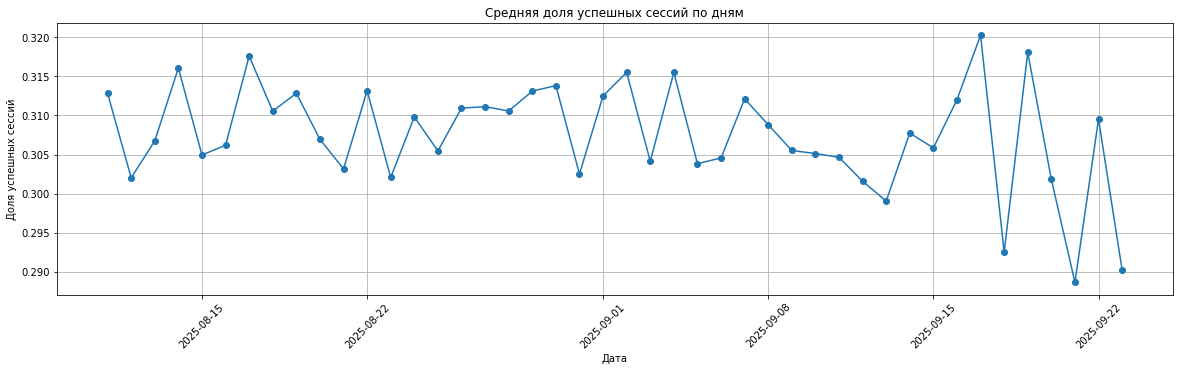

In [10]:
plt.figure(figsize=(20, 5))
plt.plot(daily_good_session['session_date'], daily_good_session['good_session_share'], marker='o')

# Настройка графика
plt.title('Средняя доля успешных сессий по дням')
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.xticks(rotation=45)  # Поворот меток по оси X для лучшей читаемости
plt.grid()

plt.show()

Средняя доля удачных сессий меняется ото дня ко дню, также отметим понижение доли к концу сентября 2025 до 0.29, однако обратим особое внимание, что значительных колебаний тем не менее не наблюдается: значения в районе 0.3  достаточно стабильно (для наглядности изменений выбран график с приближением значений в границах колебаний, а именно от 0.290 до 0.320 - самое высокое значений 2025-09-17).

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика, рассчитать необходимую длительность проведения теста.

#### 2.1. Расчёт размера выборки
В рамках курса вам уже приходилось рассчитывать размеры выборки, используя онлайн-калькуляторы. В этом задании предлагаем воспользоваться готовым кодом и рассчитать необходимое для вашего дизайна эксперимента количество пользователей.

Для этого установите в коде ниже следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки мы будем использовать метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

Запустите ячейку и изучите полученное значение.

In [11]:
from statsmodels.stats.power import NormalIndPower

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


Для одной группы расчет на 17441 участника, соответствеено для общего размера для двух групп предстоит его удвоить (у нас группы А и В).

#### 2.1. Расчёт длительности A/B-теста

Используйте данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитайте длительность теста, разделив одно на другое.

- Рассчитайте среднее количество уникальных пользователей приложения в день.

- Определите длительность теста, исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлите в большую сторону.

In [12]:
daily_users=sessions_history.groupby('session_date')['user_id'].nunique()
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = round(sum(daily_users) / len(daily_users),2)
total_sample_size=2*sample_size
# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(total_sample_size / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907.36 пользователей в день составит 4 дней


Итак, длительность теста составит 4 дня.

4 дня - это допустимый минимальный срок, однако для повышения надёжности результатов теста желательно провести его дольше — например, на 7 или даже 14 дней, чтобы сгладить возможные колебания в поведении пользователей по дням недели и собрать больше данных для анализа.    
    
Так же следует учитывать, что в последние дни было снижение активности пользователей, поэтому среднее за весь период не будет однозначно характеризовать размер активной аудитории.    


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считайте и сохраните в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитайте количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитайте и выведите на экран процентную разницу в количестве пользователей в группах A и B. Постройте любую удобную визуализацию, на которой можно было бы увидеть возможное различие двух групп.

Для расчёта процентной разницы воспользуйтесь формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [13]:
sessions_test_part=pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')
sessions_test_part.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [14]:
test_group_users=sessions_test_part.groupby('test_group')['user_id'].nunique().reset_index()
test_group_users

,test_group,user_id
0,A,1477
1,B,1466


In [15]:
group_A = test_group_users[test_group_users['test_group'] == 'A']
group_B = test_group_users[test_group_users['test_group'] == 'B']
# Вычисляем разницу
test_group_users_difference = 100 * (group_A['user_id'].mean() - group_B['user_id'].mean()) / group_A['user_id'].mean()

print(f"Разница между группами A и B: {test_group_users_difference:.2f}%")

Разница между группами A и B: 0.74%


Text(0, 0.5, '')

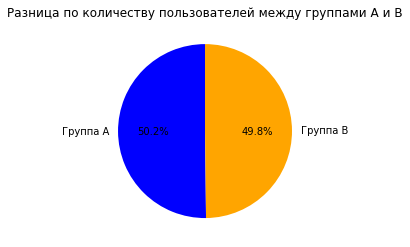

In [16]:
# Строим круговую диаграмму
test_group_users['user_id'].plot(
    kind='pie',  # Тип графика — круговая диаграмма
    autopct='%1.1f%%',  # Формат отображения процентов
    startangle=90,  # Начальный угол
    colors=['blue', 'orange'],  # Цвета секторов
    legend=False,  # Выключаем легенду
    labels=['Группа A','Группа B'])

# Настраиваем оформление графика
plt.title('Разница по количеству пользователей между группами A и B')
plt.ylabel('') 

Проверка распределения пользователей важна по нескольким причинам:
    
    
- Правильность разделения пользователей: Чтобы результат A/B-теста был корректным, важно убедиться, что группы A и B были случайным образом разделены, а не случайным образом или по какому-либо смещённому принципу. Если группы не были равномерно разделены, это может привести к ошибочным выводам, так как различия в поведении пользователей могут быть вызваны не тестируемым фактором, а изначальной неоднородностью групп.
- Корректность расчёта метрик: Мы проверяем, что метрики, такие как количество уникальных пользователей, корректно считаются для каждой из групп. Это важно, потому что любые ошибки в учёте пользователей могут исказить результаты теста и привести к неверным выводам о влиянии изменений на поведение пользователей.
- Обнаружение аномалий: Если процентная разница в количестве пользователей между группами слишком велика, это может свидетельствовать о проблемах с разделением пользователей, таких как технические ошибки или неправильное распределение. Проверка позволяет выявить такие аномалии на ранних стадиях теста и скорректировать процесс.
- Убедительность результатов: Важно, чтобы тест был честным и справедливым. Если группа A имеет значительное преимущество по численности, то результаты могут быть искажены. Это проверка помогает удостовериться, что эксперимент был проведён корректно, и что его результаты можно использовать для объективных выводов.


#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитайте количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

In [17]:
# используем метод set() для создания множеств пользователей в группах A и B.
users_A = set(sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'])
users_B = set(sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'])

# находим пересечение пользователей с помощью intersection
usersA_B= users_A.intersection(users_B)

# Количество пользователей, которые находятся в обеих группах
num_usersA_B = len(usersA_B)
num_usersA_B

0

Убедились, что никто из пользователей случайно не попал в обе группы одновременно, совпадений 0.

Альтернативный способ — использовать группировку, что может быть полезно при работе с большими данными:

```py
sessions_test_part.groupby('user_id').agg({'test_group': 'nunique'}).query('test_group > 1')
```

Этот метод позволяет сразу отфильтровать пользователей, которые встречаются в обеих группах.

#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройства и регионам.

Постройте две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение устройств в группах A и B.


In [18]:
# распределение по типу устройства
grouped_device=sessions_test_part.groupby(['device','test_group']).agg({'user_id': 'nunique'}).reset_index()
grouped_device


,device,test_group,user_id
0,Android,A,656
1,Android,B,668
2,Mac,A,156
3,Mac,B,148
4,PC,A,369
5,PC,B,381
6,iPhone,A,296
7,iPhone,B,269


In [19]:
device_counts_A = grouped_device[grouped_device['test_group'] == 'A']['device'].value_counts(normalize=True)
device_counts_B = grouped_device[grouped_device['test_group'] == 'B']['device'].value_counts(normalize=True)
device_counts_A, device_counts_B

(Mac        0.25
 iPhone     0.25
 PC         0.25
 Android    0.25
 Name: device, dtype: float64,
 Mac        0.25
 iPhone     0.25
 PC         0.25
 Android    0.25
 Name: device, dtype: float64)

Text(0, 0.5, '')

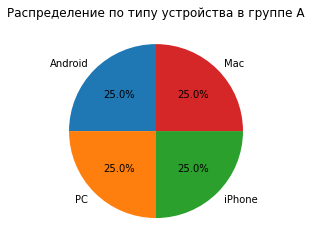

In [20]:
device_counts_A.plot(kind='pie',  # Тип графика — круговая диаграмма
    autopct='%1.1f%%',  # Формат отображения процентов
    startangle=90,  # Начальный угол
        legend=False,  # Выключаем легенду
    labels=['Android', 'PC', 'iPhone', 'Mac'])

plt.title('Распределение по типу устройства в группе А')
plt.ylabel('') 



Text(0, 0.5, '')

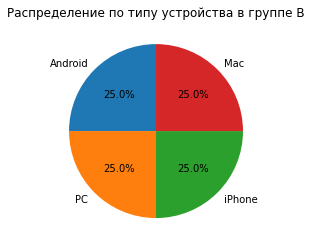

In [21]:
device_counts_B.plot(kind='pie',  # Тип графика — круговая диаграмма
    autopct='%1.1f%%',  # Формат отображения процентов
    startangle=90,  # Начальный угол
        legend=False,  # Выключаем легенду
    labels=['Android', 'PC', 'iPhone', 'Mac'])

# Настраиваем оформление графика
plt.title('Распределение по типу устройства в группе B')
plt.ylabel('') 

Построив 2 круговые диаграммы по распределению по типам устройств, видим в обеих равномерное распределение по устройствам: по 25%. 

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедитесь, что пользователи равномерно распределены по регионам.

Постройте две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение регионов в группах A и B. Постарайтесь использовать другой тип диаграммы, не тот, что в прошлом задании.


In [22]:
# распределение по региону
grouped_region=sessions_test_part.groupby(['region','test_group']).agg({'user_id': 'nunique'}).reset_index()
grouped_region

,region,test_group,user_id
0,CIS,A,644
1,CIS,B,645
2,EU,A,224
3,EU,B,217
4,MENA,A,609
5,MENA,B,604


In [23]:
region_counts_A = grouped_region[grouped_region['test_group'] == 'A']['region'].value_counts(normalize=True)
region_counts_B = grouped_region[grouped_region['test_group'] == 'B']['region'].value_counts(normalize=True)
region_counts = pd.DataFrame({
    'Group A': region_counts_A,
    'Group B': region_counts_B})
region_counts


,Group A,Group B
MENA,0.333333,0.333333
CIS,0.333333,0.333333
EU,0.333333,0.333333


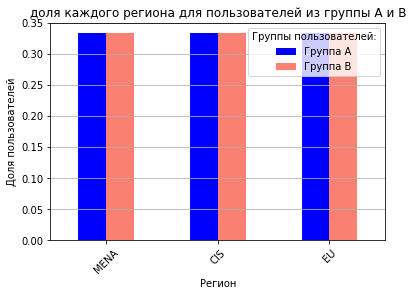

In [24]:
# Строим график
region_counts.plot(kind='bar', color=['blue', 'salmon'])
plt.title('доля каждого региона для пользователей из группы A и В')
plt.xlabel('Регион')
plt.ylabel('Доля пользователей')
plt.xticks(rotation=45)
plt.legend(title='Группы пользователей:', labels=['Группа А', 'Группа В'])
plt.grid(axis='y')
plt.show()

Наглядно видим на диаграмме, что распределение  равномерное в 2 группах: eu, cis и mena  наравне в обеих группах - 0,33.

#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста сформулируем выводы: 

- Были ли обнаружено различие в количестве пользователей в двух группах? В группе A	1477 пользователей, в группе B	- 1466, Разница между группами совсем незначительная: 0.74%.


- Являются ли выборки независимыми?
Не было обнаружено пересечение пользователей из тестовой и контрольной групп, в связи с чем считаем выборки независимыми.



- Сохраняется ли равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам?

В соответствии с проведенным мониторингом были построены диаграммы, выведены доли по устройствам и регионам и наблюдается равномерное распределение пользователей.


Можем сделать вывод о том, что А/B-тест проходит корректно.

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считайте и сохраните в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [25]:
sessions_test=pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')
sessions_test.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B


In [26]:
sessions_test['good_session']=(sessions_test['page_counter'] >= 4).astype(int)
sessions_test.head(7)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0
5,31F7A42B32103403,E9B64B779C3348ED,2025-10-20,2025-10-20 17:09:41,2025-10-19,2,0,2,CIS,PC,B,0
6,87C09E3E3B334959,FECFF83C13DC9364,2025-10-22,2025-10-22 23:51:42,2025-10-20,3,0,4,CIS,iPhone,B,1


Датафрейм загружен, новый столбец корректно сформирован.


#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и вы будете сравнивать две сопоставимые группы.

- Рассчитайте количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверьте, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы. Используйте статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведите на экран полученное значение p-value и интерпретируйте его.

Сформулирем нулевую гипотезу:  количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы. 
Альтернативной гипотезой будет наличие статистически значимых различий, то есть по количеству уникальных дневных сессий больше будет либо в группе А, чем в группе В, либо в группе В больше, чем в А, то есть alternative='two-sided'.

Будем использовать stats.ttest_ind() для проведения t-теста для независимых выборок.  (установка параметра equal_var=False может позволить не считать равными вариации выборок, однако результат теста при его устновке и в его отсутствии одинаковы).

In [27]:
# количество уникальных сессий для каждого дня и обеих тестовых групп, используем группировку
daily_unique_sessions = sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique().reset_index()

# уникальные дневные сессии для группы А и В
group_A = daily_unique_sessions[daily_unique_sessions['test_group'] == 'A']['session_id']
group_B = daily_unique_sessions[daily_unique_sessions['test_group'] == 'B']['session_id']

# Проведение t-теста для проверки равенства средних
t_stat, p_value = stats.ttest_ind(group_A, group_B, alternative='two-sided')

print(f'p-value: {p_value:.2}')

alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу. Различия между группами статистически значимы.")
else:
    print("Нет оснований отвергать нулевую гипотезу. Различия между группами не статистически значимы.")

p-value: 0.94
Нет оснований отвергать нулевую гипотезу. Различия между группами не статистически значимы.


#### 4.3. Сравнение доли успешных сессий

Когда вы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

Используйте созданный на первом шаге задания столбец `good_session` и рассчитайте долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразите на экране.

In [28]:
# группировка для подсчета успешных и всех сессий
grouped_sessions_test = sessions_test.groupby('test_group').agg(
    total_sessions=('session_id', 'count'),
    successful_sessions=('good_session', 'sum')
).reset_index()

# доля успешных сессий
grouped_sessions_test['success_share'] = grouped_sessions_test['successful_sessions'] / grouped_sessions_test['total_sessions']
grouped_sessions_test


,test_group,total_sessions,successful_sessions,success_share
0,A,49551,15248,0.307723
1,B,50454,16059,0.318290


In [29]:
# доли успешных сессий в группах А и В
success_A = grouped_sessions_test[grouped_sessions_test['test_group'] == 'A']['success_share'].values[0]
success_B = grouped_sessions_test[grouped_sessions_test['test_group'] == 'B']['success_share'].values[0]
# разница в долях между группами
difference = success_A - success_B
print (f'Разница в доле успешных сессий для выборок A и B: {difference:.2}') 

Разница в доле успешных сессий для выборок A и B: -0.011


По отрицательному значению разницы в долях в группах А и В видим превышение доли успешных сессий для выборки B на 0.011, то есть примерно на 1,1%.

Сравнение доли успешных сессий — важный шаг, потому что именно эта метрика показывает, насколько эффективно пользователи достигают целевого действия при взаимодействии с продуктом.

Если доля успешных сессий в одной из групп выше, это может говорить о том, что изменения, протестированные в этой группе, положительно повлияли на пользовательский опыт. А значит, они могут быть внедрены в основную версию продукта.

Без такой проверки невозможно оценить реальное влияние нововведения — даже если распределение сессий по группам было корректным.


#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге вы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитайте, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведите на экран полученное значение p-value и свои выводы о статистической значимости. Напомним, что уровень значимости в эксперименте был выбран на уровне 0.05.

Сформулируем нулевую гипотезу: изменение в доле успешных сессий статистически значимым не является: доля успешных сессий равна или меньше в тестовой, чем в контрольной.
Альтернативная, что изменение в метрике существенное и является статистически значимым (доля успешных сессиий изменилась значительно в большую сторону, то есть в тестовой группе больше, чем в контрольной).
Соответственно, проверим, с помощью z-тест для пропорций для успешных сессий обеих групп.   

У нас уже есть данные по доле успешных сессий в группах А и В, полученные методом values. 
Теперь получим данные по успешным сессиям из sessions_test, чтобы сформировать первый массив [ ] для z-теста,  а также получим данные об общем количестве сессий того же датафрейма для второго массива z-теста. Ранее мы уже испортировали необходимый proportions_ztest.



In [30]:

# формируем количество успешных сессий для групп А и В
successful_A = sessions_test[(sessions_test['test_group'] == 'A')&(sessions_test['good_session']==1)].shape[0]
successful_B = sessions_test[(sessions_test['test_group'] == 'B')&(sessions_test['good_session']==1)].shape[0]


# формируем общее количество сессий для групп А и В
total_A = sessions_test[(sessions_test['test_group'] == 'A')]['session_id'].nunique()
total_B = sessions_test[(sessions_test['test_group'] == 'B')]['session_id'].nunique()

# z-тест для пропорций
z_stat, p_value = proportions_ztest(
    [successful_B, successful_A], 
    [total_B, total_A], 
    alternative='larger')

# Вывод p-value и выводы
print(f'p-value: {p_value:.6f}')

alpha = 0.05
if p_value < alpha:
    print("Мы отвергаем нулевую гипотезу. Различия в доле успешных сессий статистически значимы.")
else:
    print("Нет оснований отвергать нулевую гипотезу. Различия в доле успешных сессий не статистически значимы.")

p-value: 0.000157
Мы отвергаем нулевую гипотезу. Различия в доле успешных сессий статистически значимы.


#### 4.5. Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируйте и запишите свои выводы для команды разработки приложения:

- Для эксперимента анализировались данные, где одной из важнейших метрик продукта выбрано число зарегистрированных пользователей. По историческим данным выявили устойчивую тенденцию роста доли зарегистрированных пользователей. Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы на то, что он зарегистрируется и оплатит подписку.  Успешными сессиями считали те, в рамках которых пользователь просмотрел 4 и более страниц: это говорят об удовлетворённости контентом и алгоритмами рекомендаций. 
  Необходимый размер выборки был определен для каждой группы: 17441 (то есть удваивали для общего числа), а длительность эксперимента определена в 4 дня. Было задействовано в группе A - 1477 пользователей, в группе B	- 1466 пользователей.
  Ключевой метрикой избрана доля успешных сессий.  
  Тест был независимым (пересечений по пользователям не выявлено), количество сессий в обеих выборках не различалось существенно, то есть различия не статистически значимы.
  
- Внедрение нового алгоритма рекомендаций повлияло на рост ключевой метрики: доля успешных сессий в группе A	-	0.307723, в группе В - 0.318290, рост на 1,1%.

- Значение p-value для оценки статистической значимости выявленного эффекта = 0.000157.Различия в доле успешных сессий статистически значимы

- Таким образом, новый алгоритм рекомендаций, который будет показывать более интересный контент для каждого пользователя, дает большую долю успешных сессий, и хотя разница в долях не большая не первый взгляд, всего на 1.1%, проведенный z-тест выявил, что такие изменения статистически значимы, то есть этот рост важен и позволяет внедрять новоовведение в приложение.